In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import netCDF4 as nc

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:

def preprocess_atm(ds):
    ds         = cesm_correct_time(ds)
    return ds


## Try using Sasha's script

In [4]:
varname = "tas_2m"  # User specifies: ["tas_2m", "pr_sfc"]
method = "allLeads"  # User specifies: ["allLeads", "weeks12lead", "weeks34lead", "weeks45lead"]
calculate_ensemble_mean = True  # User specifies: [True, False]
start_date = "1999-01-01" # User specifies: [eg, 1999-01-01] Note: doesn't need to be a monday
end_date = "2020-12-31"  # User specifies: [eg, 2020-12-31] Note: doesn't need to be a monday
destDir="/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/forJudith/" # User specifies 

# Check the time range if calculate_ensemble_mean is False
if not calculate_ensemble_mean:
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    time_range = (end - start).days
    if time_range > 370:
        print(f"Warning: Your time range is {time_range} days, which exceeds the 370-day limit.")
        print("When choosing to keep all members, you need to shorten your date range to less than 370 days.")
        raise ValueError("Time range exceeds the allowed limit.")  # This will stop execution

base_dir = f"/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/{varname}"
mondays = pd.date_range(start_date, end_date, freq="W-MON")

methods = {
    "allLeads": (None, np.arange(1, 47)),  # No time slicing, set time coords
    "weeks12lead": (slice(0, 14), None),
    "weeks34lead": (slice(14, 28), None),
    "weeks56lead": (slice(28, 42), None),
}
time_slice, time_coords = methods.get(method, (None, None))

# Initialize result containers
data_results, init_array = [], []

for monday in mondays:
    short_date = monday.strftime("%d%b%Y").lower()
    init_date = int(monday.strftime("%Y%m%d"))
    dir_path = os.path.join(base_dir, str(monday.year), f"{monday.month:02d}")
    print(short_date)
    if not os.path.exists(dir_path): 
        continue
    files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith("m10.nc") and short_date in f]
    if not files:
        continue
    datasets = [xr.open_dataset(fp)[[varname]] for fp in files]
    combined = xr.concat(datasets, dim="member")

    # Apply time slicing if specified
    if time_slice:
        combined = combined.isel(time=time_slice).mean(dim="time")

    # Calculate or keep all ensemble members
    data = combined.mean(dim="member").expand_dims(init=[init_date]) if calculate_ensemble_mean else combined.expand_dims(init=[init_date])

    # Assign time coordinates if available
    if time_coords is not None:
        data = data.assign_coords({"time": time_coords})

    # Store results
    data_results.append(data[varname])
    init_array.append(init_date)

# Combine results across all dates
data_combined = xr.concat(data_results, dim="init")

# Create final dataset
lon_array, lat_array = combined.lon, combined.lat
dataset = xr.Dataset({
    "lon": lon_array,
    "lat": lat_array,
    "init": init_array,
    "data": data_combined,
})


04jan1999
11jan1999
18jan1999
25jan1999
01feb1999
08feb1999
15feb1999
22feb1999
01mar1999
08mar1999
15mar1999
22mar1999
29mar1999
05apr1999
12apr1999
19apr1999
26apr1999
03may1999
10may1999
17may1999
24may1999
31may1999
07jun1999
14jun1999
21jun1999
28jun1999
05jul1999
12jul1999
19jul1999
26jul1999
02aug1999
09aug1999
16aug1999
23aug1999
30aug1999
06sep1999
13sep1999
20sep1999
27sep1999
04oct1999
11oct1999
18oct1999
25oct1999
01nov1999
08nov1999
15nov1999
22nov1999
29nov1999
06dec1999
13dec1999
20dec1999
27dec1999
03jan2000
10jan2000
17jan2000
24jan2000
31jan2000
07feb2000
14feb2000
21feb2000
28feb2000
06mar2000
13mar2000
20mar2000
27mar2000
03apr2000
10apr2000
17apr2000
24apr2000
01may2000
08may2000
15may2000
22may2000
29may2000
05jun2000
12jun2000
19jun2000
26jun2000
03jul2000
10jul2000
17jul2000
24jul2000
31jul2000
07aug2000
14aug2000
21aug2000
28aug2000
04sep2000
11sep2000
18sep2000
25sep2000
02oct2000
09oct2000
16oct2000
23oct2000
30oct2000
06nov2000
13nov2000
20nov2000
27nov2000


In [34]:
for iDates in range(len(dataset.init.values)):
    if iDates==0:
        dates = datetime.datetime.strptime(str(dataset.data.init[iDates].values), '%Y%m%d')
    else: 
        dates = np.append(dates, datetime.datetime.strptime(str(dataset.data.init[iDates].values), '%Y%m%d'))

dataset['init'] = dates


DatetimeIndex(['1999-01-04', '1999-01-11', '1999-01-18', '1999-01-25',
               '1999-02-01', '1999-02-08', '1999-02-15', '1999-02-22',
               '1999-03-01', '1999-03-08',
               ...
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28'],
              dtype='datetime64[ns]', length=1148, freq='W-MON')

In [ ]:
testDS

In [90]:
varname = "tas_2m"  # User specifies: ["tas_2m", "pr_sfc"]
method = "allLeads"  # User specifies: ["allLeads", "weeks12lead", "weeks34lead", "weeks45lead"]
calculate_ensemble_mean = True  # User specifies: [True, False]
start_date = "1999-01-01" # User specifies: [eg, 1999-01-01] Note: doesn't need to be a monday
end_date = "2021-12-31"  # User specifies: [eg, 2020-12-31] Note: doesn't need to be a monday
# destDir="/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/forJudith/" # User specifies 
destDir="/glade/derecho/scratch/mdfowler/temp/s2s/" # User specifies 

# Check the time range if calculate_ensemble_mean is False
if not calculate_ensemble_mean:
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    time_range = (end - start).days
    if time_range > 370:
        print(f"Warning: Your time range is {time_range} days, which exceeds the 370-day limit.")
        print("When choosing to keep all members, you need to shorten your date range to less than 370 days.")
        raise ValueError("Time range exceeds the allowed limit.")  # This will stop execution

base_dir = f"/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/{varname}"
mondays = pd.date_range(start_date, end_date, freq="W-MON")

methods = {
    "allLeads": (None, np.arange(1, 47)),  # No time slicing, set time coords
    "weeks12lead": (slice(0, 14), None),
    "weeks34lead": (slice(14, 28), None),
    "weeks56lead": (slice(28, 42), None),
}
time_slice, time_coords = methods.get(method, (None, None))

def getEnsMember(endsWithString):

    # Initialize result containers
    data_results, init_array = [], []
    
    for monday in mondays:
        short_date = monday.strftime("%d%b%Y").lower()
        init_date = int(monday.strftime("%Y%m%d"))
        dir_path = os.path.join(base_dir, str(monday.year), f"{monday.month:02d}")
        # print(short_date)    ## MDF commented out
        if not os.path.exists(dir_path): 
            continue
        # files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith("m10.nc") and short_date in f]
        files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(endsWithString) and short_date in f]
        if not files:
            continue
        datasets = [xr.open_dataset(fp)[[varname]] for fp in files]
        combined = xr.concat(datasets, dim="member")
    
        # Apply time slicing if specified
        if time_slice:
            combined = combined.isel(time=time_slice).mean(dim="time")
    
        # Calculate or keep all ensemble members
        data = combined.mean(dim="member").expand_dims(init=[init_date]) if calculate_ensemble_mean else combined.expand_dims(init=[init_date])
    
        # Assign time coordinates if available
        if time_coords is not None:
            data = data.assign_coords({"time": time_coords})
    
        # Store results
        data_results.append(data[varname])
        init_array.append(init_date)
    
    # Combine results across all dates
    data_combined = xr.concat(data_results, dim="init")
    
    # Create final dataset
    lon_array, lat_array = combined.lon, combined.lat
    dataset = xr.Dataset({
        "lon": lon_array,
        "lat": lat_array,
        "init": init_array,
        "data": data_combined,
    })

    return dataset

# # Save dataset
# output_path = f"{destDir}/{varname}_cesm2cam6v2_allLeads_m10.nc"
# dataset.to_netcdf(output_path)
# output_path = f"{destDir}/{varname}_cesm2cam6v2_allLeads_m10.zarr"
# dataset.to_zarr(output_path, mode='w')

In [91]:
for iEns in range(5):
    if iEns<10: 
        strSel = "m0"+str(iEns)+".nc"
    print('Working on ', strSel)

    ensDS = getEnsMember(strSel).assign_coords({"ensMember":  iEns})

    if iEns==0: 
        allEns_ds = ensDS
    else: 
        allEns_ds = xr.concat([allEns_ds, ensDS], "ensMember") 


Working on  m00.nc
Working on  m01.nc



KeyboardInterrupt



In [105]:
ensDS

<xarray.Dataset> Size: 14GB
Dimensions:    (lon: 360, lat: 181, init: 1198, time: 46)
Coordinates:
  * lon        (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * init       (init) int64 10kB 19990104 19990111 ... 20211220 20211227
  * time       (time) int64 368B 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46
    ensMember  int64 8B 0
Data variables:
    data       (init, time, lat, lon) float32 14GB 250.4 250.4 ... 244.4 244.4

In [104]:
ensDS.init


<xarray.DataArray 'init' (init: 1198)> Size: 10kB
array([19990104, 19990111, 19990118, ..., 20211213, 20211220, 20211227])
Coordinates:
  * init       (init) int64 10kB 19990104 19990111 ... 20211220 20211227
    ensMember  int64 8B 0

## Use version that claude.ai converted from matlab to python:


In [115]:
def compute_climatology(var_name_in, case_name, scenario):
    # File paths
    file_listing_path = f'/glade/work/sglanvil/CCR/S2S/fileListings/{var_name_in}.S2S.{case_name}.{scenario}'
    nc_save_path = f'/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/{var_name_in}_clim_{case_name}.{scenario}_s2s_data.nc'

    # Initialize tracking variables
    date_str_previous = '01jan1000'  # arbitrary old date
    blah = 0
    x = 0
    ens_avg = None
    
    # Daily climatology arrays
    clim_bin = None
    clim_bin_days = None

    # Read file listing
    with open(file_listing_path, 'r') as file_list:
        for tline in file_list:
            fil = tline.strip()
            print(f"Processing file: {fil}")
            
            flag = False
            try:
                # Extract date from filename
                date_str = fil.split(f'{case_name}_')[1].split('_00z_d01')[0]
                start_time = datetime.datetime.strptime(date_str, '%d%b%Y')
                doy = start_time.timetuple().tm_yday
                
                # Leap year adjustment
                if start_time.year % 4 == 0 and start_time.month > 2:
                    doy -= 1

                # Read netCDF data
                with nc.Dataset(fil, 'r') as ncfile:
                    var = ncfile.variables[var_name_in][:]
                    
                    # Diagnostic print for variable size
                    # print(f"Variable shape: {var.shape}")
                    
                    # First iteration: initialize arrays
                    if blah == 0:
                        clim_bin = np.zeros((*var.shape, 365))
                        clim_bin_days = np.zeros((*var.shape, 365))
                        lon = ncfile.variables['lon'][:]
                        lat = ncfile.variables['lat'][:]

            except Exception as e:
                print(f'Error reading file {fil}: {e}')
                flag = True
                continue

            # # Validate data size with more detailed error handling
            # expected_size = 46  # From original MATLAB code
            # if var.shape[2] != expected_size:
            #     print(f'Error: Data size is {var.shape[2]}, expected {expected_size}')
            #     # Instead of NaN, you might want to skip this file or handle differently
            #     continue

            # Rest of the processing remains the same...
            if date_str == date_str_previous:
                x += 1
                ens_avg = (ens_avg * (x-1) + var) / x
            else:
                # Store previous day's ensemble average
                if blah != 0 and ens_avg is not None:
                    clim_bin[..., doy_previous-1] += ens_avg
                    clim_bin_days[..., doy_previous-1] += 1

                ens_avg = var
                x = 1

            date_str_previous = date_str
            doy_previous = doy
            blah += 1

        # Final day processing
        clim_bin[..., doy_previous-1] += ens_avg
        clim_bin_days[..., doy_previous-1] += 1

    # Compute climatology
    clim = clim_bin / clim_bin_days

    return clim, lon, lat

In [99]:
var_name_in = 'tas_2m'
case_name = 'cesm2cam6climoATMv2'
scenario = 'scenario4'

In [116]:
clim, lon, lat = compute_climatology('tas_2m', 'cesm2cam6climoATMv2', 'scenario4')

Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m00.nc
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m01.nc
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m02.nc
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m03.nc
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m04.nc
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/

KeyboardInterrupt: 

In [102]:
# File paths
file_listing_path = f'/glade/work/sglanvil/CCR/S2S/fileListings/{var_name_in}.S2S.{case_name}.{scenario}'
nc_save_path = f'/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/{var_name_in}_clim_{case_name}.{scenario}_s2s_data.nc'

# Initialize tracking variables
date_str_previous = '01jan1000'  # arbitrary old date
blah = 0
x = 0
ens_avg = None

# Daily climatology arrays
clim_bin = None
clim_bin_days = None

# Read file listing
with open(file_listing_path, 'r') as file_list:
    for tline in file_list:
        fil = tline.strip()
        print(f"Processing file: {fil}")
        
        flag = False
        try:
            # Extract date from filename
            date_str = fil.split(f'{case_name}_')[1].split('_00z_d01')[0]
            start_time = datetime.datetime.strptime(date_str, '%d%b%Y')
            doy = start_time.timetuple().tm_yday
            
            # Leap year adjustment
            if start_time.year % 4 == 0 and start_time.month > 2:
                doy -= 1

            # Read netCDF data
            with nc.Dataset(fil, 'r') as ncfile:
                var = ncfile.variables[var_name_in][:]
                
                # Diagnostic print for variable size
                print(f"Variable shape: {var.shape}")
                
                # First iteration: initialize arrays
                if blah == 0:
                    clim_bin = np.zeros((*var.shape, 365))
                    clim_bin_days = np.zeros((*var.shape, 365))
                    lon = ncfile.variables['lon'][:]
                    lat = ncfile.variables['lat'][:]


        except Exception as e:
            print(f'Error reading file {fil}: {e}')
            flag = True
            continue


Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m00.nc
Variable shape: (46, 181, 360)
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m01.nc
Variable shape: (46, 181, 360)
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m02.nc
Variable shape: (46, 181, 360)
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m03.nc
Variable shape: (46, 181, 360)
Processing file: /glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoATM/postprocess/p1/tas_2m/1999/01/tas_2m_cesm2cam6climoATMv2_04jan1999_00z_d01_d46_m04

KeyboardInterrupt: 

## Read in ens data (my attempt)

In [12]:
varname = "tas_2m"  # User specifies: ["tas_2m", "pr_sfc"]
method = "allLeads"  # User specifies: ["allLeads", "weeks12lead", "weeks34lead", "weeks45lead"]
calculate_ensemble_mean = True  # User specifies: [True, False]
start_date = "1999-01-01" # User specifies: [eg, 1999-01-01] Note: doesn't need to be a monday
end_date = "2020-12-31"  # User specifies: [eg, 2020-12-31] Note: doesn't need to be a monday
destDir="/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/forJudith/" # User specifies 

# Check the time range if calculate_ensemble_mean is False
if not calculate_ensemble_mean:
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    time_range = (end - start).days
    if time_range > 370:
        print(f"Warning: Your time range is {time_range} days, which exceeds the 370-day limit.")
        print("When choosing to keep all members, you need to shorten your date range to less than 370 days.")
        raise ValueError("Time range exceeds the allowed limit.")  # This will stop execution

base_dir = f"/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/{varname}"
mondays = pd.date_range(start_date, end_date, freq="W-MON")


In [144]:
def get_climatology_ensMember(ensSel): 
    fileList = np.sort(glob.glob(base_dir+'/*/*/*'+ensSel+'.nc'))
        
    count=0 
    for monday in mondays:
        if count==0:
            short_date = monday.strftime("%d%b%Y").lower()
            count = count+1
        else:
            short_date = np.append(short_date, monday.strftime("%d%b%Y").lower())
            count = count+1
    
    selFiles = [ele for ele in fileList for x in short_date if x in ele]

    ds_1 = xr.open_dataset(selFiles[0])
    ntime,nlat,nlon = np.shape(ds_1.tas_2m)

    tas_2m_doy = np.zeros( [365, nlat, nlon] )
    ndays_doy  = np.zeros( [365, nlat, nlon] )
    
    for iFile in range(len(selFiles)):
        fileInfo = selFiles[iFile].split('/')[-1]
        # print(fileInfo)
    
        initDate_str = fileInfo.split('_')[3]
        initDate     =  datetime.datetime.strptime(str(initDate_str), '%d%b%Y')
        ensMember    = fileInfo.split('_')[-1].split('.')[0]
    
        ds = xr.open_dataset(selFiles[iFile])
    
        doy = ds['time.dayofyear'].values - 1  ## Subtracting one to start with day zero (zero indexing in arrays)
    
        if ( (any(doy==364)) & (any(doy==0)) ):
            iNewYear = np.where(doy==0)[0][0]
            tas_2m_doy[doy[0]::, :,:]      = tas_2m_doy[doy[0]::, :,:] + ds.tas_2m.values[0:iNewYear,:,:]
            tas_2m_doy[0:(doy[-1]+1), :,:] = tas_2m_doy[0:(doy[-1]+1), :,:] + ds.tas_2m.values[iNewYear::,:,:]
    
            ndays_doy[doy[0]::, :,:]       = ndays_doy[doy[0]::, :,:] + 1
            ndays_doy[0:(doy[-1]+1), :,:]  = ndays_doy[0:(doy[-1]+1), :,:] + 1
            
            print('Split across two years for file ', fileInfo)
        else: 
            tas_2m_doy[doy[0]:(doy[-1]+1), :,:] = tas_2m_doy[doy[0]:(doy[-1]+1), :,:] + ds.tas_2m.values
            ndays_doy[doy[0]:(doy[-1]+1), :,:]  = ndays_doy[doy[0]:(doy[-1]+1), :,:] + 1
        
    
    # Get climo: 
    print('Computing full climo')
    tas_2m_ensMember = tas_2m_doy/ndays_doy

    climo_ds  = xr.Dataset({
        "lon": ds.lon.values,
        "lat": ds.lat.values,
        "doy": np.arange(365),
        "tas": (('doy', 'lat','lon'), tas_2m_ensMember),
    })

    return climo_ds

In [152]:
%%time
tas_2m_m04_ds = get_climatology_ensMember('m04')

filePath='/glade/derecho/scratch/mdfowler/temp/s2s/tas_annClimo_m04.nc'
tas_2m_m04_ds.to_netcdf(filePath)


Split across two years for file  tas_2m_cesm2cam6v2_22nov1999_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_29nov1999_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_06dec1999_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_13dec1999_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_20dec1999_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_27dec1999_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_20nov2000_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_27nov2000_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_04dec2000_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_11dec2000_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_18dec2000_00z_d01_d46_m04.nc
Split across two years for file  tas_2m_cesm2cam6v2_25dec2000_00z_d01_d46_m04.nc
Split across two years for f

In [149]:
# filePath='/glade/derecho/scratch/mdfowler/temp/s2s/tas_annClimo_m01.nc'
# tas_2m_m01_ds.to_netcdf(filePath)

In [51]:
# ensSel = 'm00'

# fileList = np.sort(glob.glob(base_dir+'/*/*/*'+ensSel+'.nc'))
    
# count=0 
# for monday in mondays:
#     if count==0:
#         short_date = monday.strftime("%d%b%Y").lower()
#         count = count+1
#     else:
#         short_date = np.append(short_date, monday.strftime("%d%b%Y").lower())
#         count = count+1

# selFiles = [ele for ele in fileList for x in short_date if x in ele]




In [63]:
# ds_1 = xr.open_dataset(selFiles[0])

In [65]:
# ntime,nlat,nlon = np.shape(ds_1.tas_2m)

In [132]:
# %%time 

# tas_2m_doy = np.zeros( [365, nlat, nlon] )
# ndays_doy  = np.zeros( [365, nlat, nlon] )

# for iFile in range(len(selFiles)):
#     fileInfo = selFiles[iFile].split('/')[-1]
#     # print(fileInfo)

#     initDate_str = fileInfo.split('_')[3]
#     initDate     =  datetime.datetime.strptime(str(initDate_str), '%d%b%Y')
#     ensMember    = fileInfo.split('_')[-1].split('.')[0]

#     ds = xr.open_dataset(selFiles[iFile])

#     doy = ds['time.dayofyear'].values - 1  ## Subtracting one to start with day zero (zero indexing in arrays)

#     if ( (any(doy==364)) & (any(doy==0)) ):
#         iNewYear = np.where(doy==0)[0][0]
#         tas_2m_doy[doy[0]::, :,:]      = tas_2m_doy[doy[0]::, :,:] + ds.tas_2m.values[0:iNewYear,:,:]
#         tas_2m_doy[0:(doy[-1]+1), :,:] = tas_2m_doy[0:(doy[-1]+1), :,:] + ds.tas_2m.values[iNewYear::,:,:]

#         ndays_doy[doy[0]::, :,:]       = ndays_doy[doy[0]::, :,:] + 1
#         ndays_doy[0:(doy[-1]+1), :,:]  = ndays_doy[0:(doy[-1]+1), :,:] + 1
        
#         # print('Split across two years for file ', fileInfo)
#     else: 
#         tas_2m_doy[doy[0]:(doy[-1]+1), :,:] = tas_2m_doy[doy[0]:(doy[-1]+1), :,:] + ds.tas_2m.values
#         ndays_doy[doy[0]:(doy[-1]+1), :,:]  = ndays_doy[doy[0]:(doy[-1]+1), :,:] + 1
    

# # Get climo: 
# print('Computing full climo')
# tas_2m_m00 = tas_2m_doy/ndays_doy



Split across two years for file  tas_2m_cesm2cam6v2_22nov1999_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_29nov1999_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_06dec1999_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_13dec1999_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_20dec1999_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_27dec1999_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_20nov2000_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_27nov2000_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_04dec2000_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_11dec2000_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_18dec2000_00z_d01_d46_m00.nc
Split across two years for file  tas_2m_cesm2cam6v2_25dec2000_00z_d01_d46_m00.nc
Split across two years for f

In [141]:
# tas_2m_m00_ds  = xr.Dataset({
#         "lon": ds.lon.values,
#         "lat": ds.lat.values,
#         "doy": np.arange(365),
#         "tas": (('doy', 'lat','lon'), tas_2m_m00),
#     })


In [148]:
tas_2m_m01_ds.tas - tas_2m_m00_ds.tas

<xarray.DataArray 'tas' (doy: 365, lat: 181, lon: 360)> Size: 190MB
array([[[ 0.31819469,  0.31821752,  0.31822089, ...,  0.31823141,
          0.31820489,  0.31819405],
        [ 0.30052417,  0.30046797,  0.29851116, ...,  0.30115399,
          0.30064603,  0.29953234],
        [ 0.24825692,  0.24647185,  0.24350618, ...,  0.25666388,
          0.25367589,  0.25109158],
        ...,
        [ 0.84031446,  0.84234409,  0.84347145, ...,  0.82728966,
          0.83194317,  0.83615565],
        [ 0.83800017,  0.83773341,  0.83744412, ...,  0.83846667,
          0.83844194,  0.83822495],
        [ 0.936756  ,  0.93653964,  0.93633665, ...,  0.93753262,
          0.93725344,  0.93699657]],

       [[ 0.3184342 ,  0.31846777,  0.31847061, ...,  0.31843598,
          0.31841125,  0.31841273],
        [ 0.24088282,  0.23914332,  0.235493  , ...,  0.24400835,
          0.24451483,  0.24354027],
        [ 0.18367562,  0.1788269 ,  0.17429389, ...,  0.20429435,
          0.19752923,  0.19128681],
...
        [ 0.20714887,  0.21906079,  0.23092111, ...,  0.17534881,
          0.18613921,  0.19645415],
        [ 0.16888279,  0.17171054,  0.17472204, ...,  0.15950987,
          0.16304535,  0.16605875],
        [ 0.19503127,  0.19508362,  0.1951313 , ...,  0.19484901,
          0.19491355,  0.19497437]],

       [[ 0.01400031,  0.01433526,  0.01440082, ...,  0.01437073,
          0.01423045,  0.01402735],
        [-0.06332029, -0.0628339 , -0.0618987 , ..., -0.06694746,
         -0.06509968, -0.06458288],
        [-0.17355683, -0.16985726, -0.1647443 , ..., -0.18826746,
         -0.18416485, -0.17897328],
        ...,
        [ 0.65004009,  0.66053877,  0.67078226, ...,  0.61652516,
          0.62713265,  0.63842226],
        [ 0.93793103,  0.94268883,  0.94762457, ...,  0.92539336,
          0.92900548,  0.93330394],
        [ 1.12670635,  1.12644506,  1.12620113, ...,  1.12763882,
          1.1273046 ,  1.12699448]]])
Coordinates:
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * doy      (doy) int64 3kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363 364

In [142]:
tas_2m_m00_ds

<xarray.Dataset> Size: 190MB
Dimensions:    (lon: 360, lat: 181, doy: 365)
Coordinates:
  * lon        (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * doy        (doy) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Data variables:
    ensMember  int64 8B 0
    tas        (doy, lat, lon) float64 190MB 249.5 249.5 249.5 ... 245.5 245.5

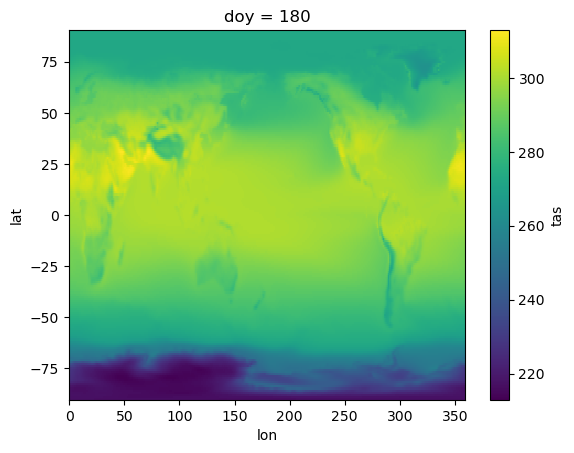

In [140]:
tas_2m_m00_ds.tas.isel(doy=180).plot()


In [31]:
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/'
dateSel = '2021-07-'

# Get filenames 
listFiles_ens0  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.00.cam.h2*'))
listFiles_ens1  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.01.cam.h2*'))
listFiles_ens2  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.02.cam.h2*'))
listFiles_ens3  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.03.cam.h2*'))
listFiles_ens4  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.04.cam.h2*'))
listFiles_ens5  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.05.cam.h2*'))
listFiles_ens6  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.06.cam.h2*'))
listFiles_ens7  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.07.cam.h2*'))
listFiles_ens8  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.08.cam.h2*'))
listFiles_ens9  = np.sort(glob.glob(dataDir+'*'+dateSel+'*.09.cam.h2*'))
listFiles_ens10 = np.sort(glob.glob(dataDir+'*'+dateSel+'*.10.cam.h2*'))
listFiles_ens11 = np.sort(glob.glob(dataDir+'*'+dateSel+'*.11.cam.h2*'))

## Read in the ensemble data 

# In some situations, it seems like there's initializations on more than just once a week; so trying to modify 
iKeep = []
for iFile in range(len(listFiles_ens0)): 
    thisDate = listFiles_ens0[iFile].split('.')[1].split('-')
    thisDate_datetime = datetime.date(int(thisDate[0]), int(thisDate[1]), int(thisDate[2]))
    nextDate = thisDate_datetime + timedelta(days=7)
    matchString = str(nextDate.year)+'-'+nextDate.strftime('%m')+'-'+nextDate.strftime('%d')
    
    if any(matchString in filename for filename in listFiles_ens0): 
        iKeep = np.append(iKeep, iFile)
        iKeep = np.append()
    
    

ds_ens0 = xr.open_mfdataset(listFiles_ens0,  preprocess=preprocess_atm, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')




In [36]:
mondays

DatetimeIndex(['1999-01-04', '1999-01-11', '1999-01-18', '1999-01-25',
               '1999-02-01', '1999-02-08', '1999-02-15', '1999-02-22',
               '1999-03-01', '1999-03-08',
               ...
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28'],
              dtype='datetime64[ns]', length=1148, freq='W-MON')

In [32]:
thisDate = listFiles_ens0[0].split('.')[1].split('-')

In [45]:
thisDate_datetime = datetime.date(int(thisDate[0]), int(thisDate[1]), int(thisDate[2]))


In [63]:
nextDate = thisDate_datetime + timedelta(days=7)

matchString = str(nextDate.year)+'-'+nextDate.strftime('%m')+'-'+nextDate.strftime('%d')


In [64]:
matchString

'2021-07-12'

In [65]:
if any(matchString in filename for filename in listFiles_ens0): 
    print('true')

true


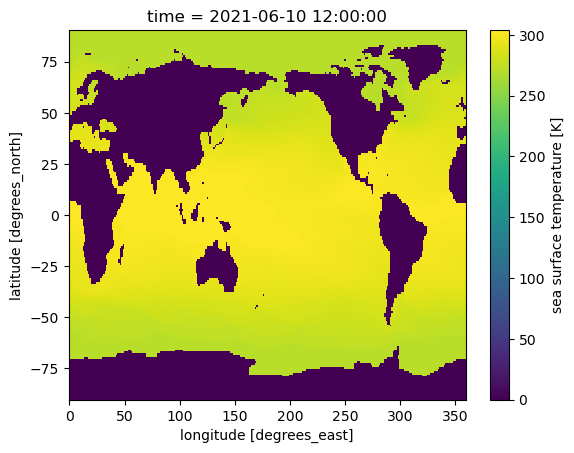

In [8]:
ds_ens0.isel(time=10).SST.plot()